<a href="https://colab.research.google.com/github/richardmukechiwa/Pnuemonia-Xray-ImageClassification/blob/main/PnuemoniaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# checking libraries
#!pip list

# **Import Libraries**

In [5]:
import os
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import models
from torchvision.models import resnet18, resnet34

# **Load Data**

In [6]:
# Check if GPU is available
print("Is GPU available:", torch.cuda.is_available())

# Get GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))



Is GPU available: False


In [7]:
# define data directories
train_path = ("/content/drive/MyDrive/chest_xray/train")
test_path = ("/content/drive/MyDrive/chest_xray/test")
val_path = ("/content/drive/MyDrive/chest_xray/val")


# **Data Exploration**

In [8]:
# converting images to RGB
class ConvertToRGB():
  def __call__(self, img):
    if img.mode != 'RGB':
      img = img.convert("RGB")
    return img

# defining transforms

transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),


    ]
)


In [9]:
# creating  data sets using ImageFolder
train_dataset = datasets.ImageFolder(root = train_path, transform = transform)
val_dataset = datasets.ImageFolder(root = val_path, transform = transform)
test_dataset = datasets.ImageFolder(root = test_path, transform = transform)



In [10]:

#Total number datapoints in each dataset
print("Total train images", len(train_dataset))
print("Total val images", len(val_dataset))
print("Total test images", len(test_dataset))


Total train images 3329
Total val images 20
Total test images 171


In [11]:
# Visualize a sample image
def image_label(i):
  image, label = train_dataset[i]
  0 <= i <= len(train_dataset)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(f"Label: {label}")
  plt.show()


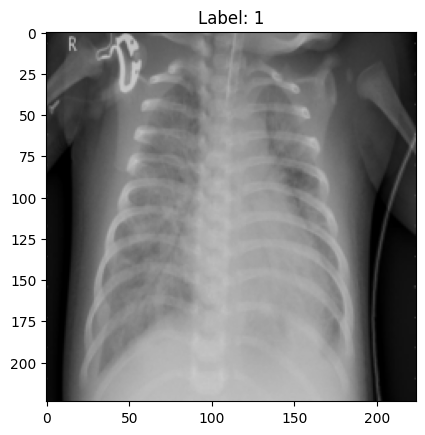

In [12]:
# using the function to get an image
image_label(368)

In [13]:
#checking train dataset classes

print("  Classes for training dataset")
print(train_dataset.classes)
print(f"That's {len(train_dataset.classes)}, classes")
print()
print("Tensor shape for one image is")
print(train_dataset[0][0].shape)

  Classes for training dataset
['normal', 'pneumonia']
That's 2, classes

Tensor shape for one image is
torch.Size([3, 224, 224])


In [14]:
# Classes balance verification

im = train_dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('/content/drive/MyDrive/chest_xray/train/normal/IM-0115-0001 - Copy (2) - Copy - Copy.jpeg', 0)
{0, 1}


In [18]:
# class counts
from collections import Counter

def class_counts(dataset):
  c = Counter(x[1] for x in tqdm(dataset))
  class_to_index = dataset.class_to_idx
  return pd.Series({cat: c[idx]  for cat, idx in class_to_index.items()})


In [19]:
#class counts for train data
train_count = class_counts(train_dataset)
train_count

  0%|          | 0/3329 [00:00<?, ?it/s]

,0
normal,352
pneumonia,2977


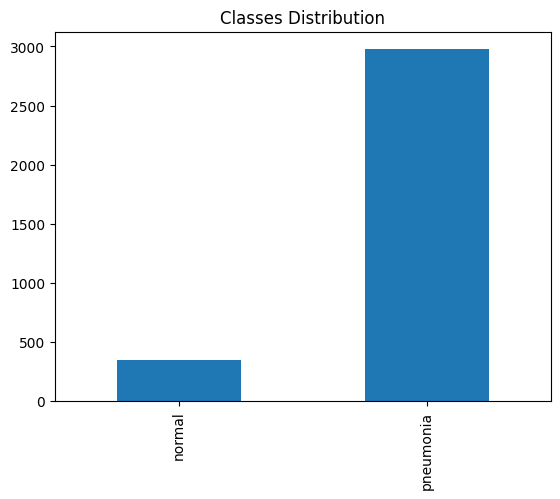

In [22]:
# plot the class counts
train_count.plot(kind = 'bar')
plt.title("Classes Distribution");

### **There is an imbalance in the train data between the normal and pneumonia class**

In [23]:
#normalizing the data using transforms

transform_norm = transforms.Compose(

     [
       ConvertToRGB(),
       transforms.Resize((224, 224)),
       transforms.ToTensor(),
       transforms.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])


In [24]:
train_dataset_norm = datasets.ImageFolder(root = train_path, transform = transform_norm)
val_dataset_norm = datasets.ImageFolder(root = val_path, transform = transform_norm)

# **Model Development**

In [ ]:
# Use the resnet18 model




In [ ]:
# creating a dataloader with "train_dataset"
batch_size = 32

train_data_loader = DataLoader(train_dataset, batch_size = batch_size)

batch_shape = next(iter(train_data_loader))[0].shape

print('The batch shape is ', batch_shape)

In [ ]:
# Initialize variables to accumulate pixel values
def get_mean_std(loader)
mean = torch.zeros(3)  # Assuming 3 channels (e.g., RGB)
std = torch.zeros(3)

# Iterate over the dataset to calculate mean and std
for images, _ in loader:
    # Images shape: [batch_size, channels, height, width]
    for i in range(3):  # Iterate over RGB channels
        mean[i] += images[:, i, :, :].mean()
        std[i] += images[:, i, :, :].std()

# Divide by the number of batches to get the average
mean /= len(loader)
std /= len(loader)

print(f"Mean: {mean}")
print(f"Std: {std}")

In [ ]:
mean, std = get_mean_std(train_data_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

In [ ]:
from typing import Counter
def class_counts(dataset):
  c = Counter(x[1] for x in tqdm(dataset))
  class_to_index = dataset.dataset.class_to_idx
  return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


In [ ]:

train_counts = class_counts(train_dataset)
train_counts.plot(kind = 'bar')